In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version

In [2]:
import tensorflow.keras as keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras import losses
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import load_model

Using TensorFlow backend.


In [3]:
import tensorflow as tf

print(tf.__version__)

1.14.0


In [4]:
%load_ext tensorboard

In [5]:
from sklearn.metrics import confusion_matrix
import itertools

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

samples= 5
tipo = 3    # np.random.randint(4)
index_image = np.random.randint(100000)  


# ========== EXTRACCIÓN DE DATOS ==============
archivo = open('./dataset/HiTS2013_100k_samples(4_channels)_images_labels.pkl',"rb")
example_dict= pickle.load(archivo)
print(example_dict['labels'].shape)
print(example_dict['images'].shape)

(100000,)
(100000, 21, 21, 4)


In [8]:
xx = example_dict['images'][:, :, :, tipo]
yy= example_dict['labels']
print(xx[:75000].shape)
print(xx[75000:].shape)
print(yy[:75000].shape[0])
print(yy[75000:].shape[0])
print(yy[:100])
#database to train
x_train=xx[:75000]
y_train=yy[:75000]

#database to test
x_test=xx[75000:]
y_test=yy[75000:]


input_shape1=x_test.shape[1]
input_shape2=x_test.shape[2]
print('\n\ninput_shape: ' , input_shape1, 'x', input_shape2)

input_shape = (input_shape1, input_shape2, 1)

(75000, 21, 21)
(25000, 21, 21)
75000
25000
[0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1
 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 0]


input_shape:  21 x 21


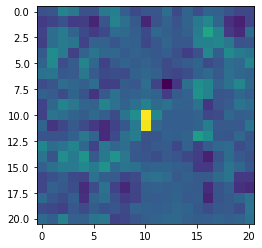

In [9]:
%matplotlib inline
plt.imshow(x_train[0])#,cmap=plt.cm.binary)
plt.show()

In [10]:
print('falso: ', y_train[0])

falso:  0


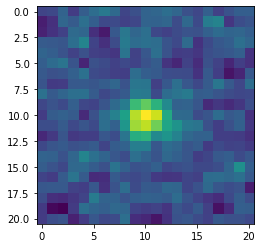

In [11]:
%matplotlib inline
plt.imshow(x_train[4])#,cmap=plt.cm.binary)
plt.show()

In [12]:
print('positivo: ', y_train[4])

positivo:  1


In [13]:
# Reshape the images.
r_x_train= np.expand_dims(x_train, axis=3)
r_x_test = np.expand_dims(x_test, axis=3)

In [14]:
############ modelo MLP #################

#model = tf.keras.models.Sequential()
 
#capas

#model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
#model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
#model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))


############ modelo Conv test #################


#model = Sequential()
#model.add(Conv2D(32, (3, 3), input_shape=input_shape))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(32, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))


#model.add(Flatten())
#model.add(Dense(32))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(2))
#model.add(Activation('softmax'))


############ modelo Conv Keras #################


#model = Sequential([
#  Conv2D(num_filters, filter_size, input_shape=input_shape),
#  MaxPooling2D(pool_size=pool_size),
#  Flatten(),
#  Dense(10, activation='softmax'),
#])


#########################################################
##                    Sin Zero Padding                 ##      
#########################################################
##    21x21x1 -> 19x19x8 -> 9x9x8 -> FC=10 -> FC=2     ##
#########################################################


#########################################################
##                    Con Zero Padding                 ##
#########################################################
##    21x21x1 -> 21x21x8 -> 10x10x8 -> FC=10 -> FC=2   ##
#########################################################

def CNN_model(num_filters = 8 , filter_size = 3, pool_size = 2, batch= 10):
    #num_filters = 8  #profundidad
    #filter_size = 3  #3x3 filter (conv3)
    #pool_size = 2    # Max Pooling de 2
    #batch= 10        #batch size


    model = Sequential([
      Conv2D(num_filters, filter_size, padding='same', input_shape=input_shape),
      MaxPooling2D(pool_size=pool_size),
    ])

    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    sgd = optimizers.SGD(lr=0.01)   #Stochastic gradient descent optimizer
    loss_cce = losses.sparse_categorical_crossentropy   #sparse categorical crossentropy

    model.compile(optimizer=sgd,
                  loss=loss_cce,
                  metrics=['accuracy'])
    return model

In [15]:
model=CNN_model()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 21, 21, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                8010      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
__________

In [17]:
#entrenar
epocas=5
batch=10

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(r_x_train, y_train, validation_split=0.25, batch_size=batch, epochs=epocas,callbacks=[es]) #[tensorboard_callback])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 56250 samples, validate on 18750 samples
Epoch 1/5
56250/56250 [==============================] - 27s 474us/step - loss: 0.4000 - acc: 0.8119 - val_loss: 0.1737 - val_acc: 0.9437
Epoch 2/5
56250/56250 [==============================] - 26s 458us/step - loss: 0.2445 - acc: 0.8917 - val_loss: 0.1446 - val_acc: 0.9497
Epoch 3/5
56250/56250 [==============================] - 26s 468us/step - loss: 0.2112 - acc: 0.9140 - val_loss: 0.1378 - val_acc: 0.9513
Epoch 4/5
56250/56250 [==============================] - 26s 467us/step - loss: 0.2000 - acc: 0.9169 - val_loss: 0.1361 - val_acc: 0.9502
Epoch 5/5
56250/56250 [==============================] - 27s 484us/step - loss: 0.1947 - acc: 0.9211 - val_loss: 0.1401 - val_acc: 0.9459
Epoch 00005: early stopping


In [18]:
print('\n\nTesting Accuracy y Loss...\n\n')

val_loss, val_acc = model.evaluate(r_x_test, y_test)
print('\n\nLoss:', val_loss*100,'%\n\n')
print('Accuracy:', val_acc*100,'%\n\n')



Testing Accuracy y Loss...


25000/25000 [==============================] - 2s 64us/step


Loss: 14.458135744988917 %


Accuracy: 94.612 %




In [19]:
model.save('super_nova_class.model')

In [20]:
new_model = load_model('super_nova_class.model')

In [21]:
predictions_t = new_model.predict(r_x_test, batch_size=batch)
print(predictions_t)

[[4.7327813e-02 9.5267218e-01]
 [3.2445537e-03 9.9675542e-01]
 [4.0350791e-02 9.5964915e-01]
 ...
 [9.7776389e-01 2.2236157e-02]
 [9.9834931e-01 1.6507376e-03]
 [9.9937648e-01 6.2350568e-04]]


In [22]:
for i in range(20):
    print('prediction: ',np.argmax(predictions_t[i]), ' -----  true class: ', y_test[i])
    

prediction:  1  -----  true class:  1
prediction:  1  -----  true class:  1
prediction:  1  -----  true class:  1
prediction:  1  -----  true class:  0
prediction:  0  -----  true class:  0
prediction:  1  -----  true class:  1
prediction:  1  -----  true class:  1
prediction:  1  -----  true class:  0
prediction:  0  -----  true class:  0
prediction:  0  -----  true class:  0
prediction:  1  -----  true class:  1
prediction:  1  -----  true class:  1
prediction:  0  -----  true class:  0
prediction:  1  -----  true class:  1
prediction:  0  -----  true class:  0
prediction:  1  -----  true class:  1
prediction:  0  -----  true class:  0
prediction:  1  -----  true class:  1
prediction:  0  -----  true class:  0
prediction:  0  -----  true class:  0


In [23]:
Samples=30

# Predict on the first 5 test images.
predictions = model.predict(r_x_test[:Samples], batch_size=batch)


#r=range(Samples)
#l = [*r]
#print (l[:Samples])

# Print our model's predictions.
print('predict ', np.argmax(predictions, axis=1)) 

# Check our predictions against the ground truths.
print('class:  ', y_test[:Samples])



predict  [1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0]
class:   [1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0]


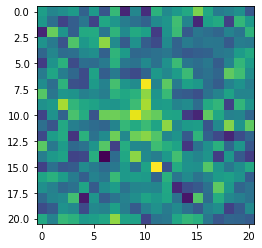

 imagem: 3 ----- tipo: 3 ----- class: 0 ----- prediction: 1 


In [24]:
%matplotlib inline
index_img=3
plt.figure("imagem: {} , tipo: {} , class: {}".format(index_img, tipo, y_test[index_img]))
plt.imshow(x_test[0])#,cmap=plt.cm.binary)


plt.show()
print(" imagem: {} ----- tipo: {} ----- class: {} ----- prediction: {} ".format(index_img, tipo, y_test[index_img], np.argmax(predictions[index_img])))


In [25]:
imagene_index=3


test_predict = model.predict(r_x_test[imagene_index:imagene_index+1], batch_size=batch)
print('prediction test: ', test_predict)
print('prediction class test: ', np.argmax(test_predict), 'percentage: ', "%.2f" % (test_predict[0][np.argmax(test_predict)]*100), '%')

if(np.argmax(test_predict)==y_test[imagene_index]):
    print('acertou!')
else:
    print('errou!')


prediction test:  [[0.12078384 0.87921613]]
prediction class test:  1 percentage:  87.92 %
errou!


In [26]:
r_x_train[0].shape

(21, 21, 1)

In [27]:
x_train[0].shape

(21, 21)

In [28]:
imagene_index_t=0
typ_im=1


xx_test = example_dict['images'][:, :, :, typ_im]

r_xx_test= np.expand_dims(xx_test, axis=3)

test_predict_t = model.predict(r_xx_test[imagene_index_t:imagene_index_t+1])
print('prediction test: ', test_predict_t)
print('\n\n\nprediction class test: ', np.argmax(test_predict_t), 'percentage: ', "%.2f" % (test_predict_t[0][np.argmax(test_predict_t)]*100), '%')
print()
if(np.argmax(test_predict)==y_test[imagene_index_t]):
    print('acertou!')
else:
    print('errou!')


prediction test:  [[0.95296544 0.0470346 ]]



prediction class test:  0 percentage:  95.30 %

acertou!


In [29]:
print('list: ',history.history.keys())
print('loss: ',history.history['val_loss'])

list:  dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
loss:  [0.17371466309887668, 0.14464320740085096, 0.13783408728027716, 0.13609345389427618, 0.14009023989595784]


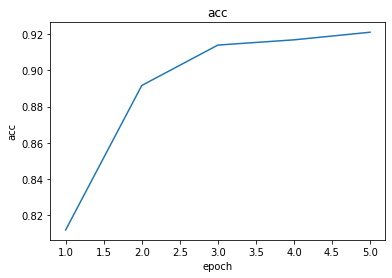

In [30]:
parametro='acc'

x_axis = np.arange(1,len(history.history[parametro])+1,1)
y_axis = history.history[parametro]

plt.plot(x_axis,y_axis)
plt.xlabel('epoch')
plt.ylabel(parametro)
plt.title(parametro)
plt.show()

In [31]:
unos_train=0
ceros_train=0
unos_test=0
ceros_test=0

for val_train in y_train:

    if val_train==1:
        unos_train+=1
    else:
        ceros_train+=1


for val_test in y_test:

    if val_test==1:
        unos_test+=1
    else:
        ceros_test+=1    
        
print('unos_train: ', unos_train)
print('ceros_train: ', ceros_train)
print('percentage: %.2f' % (100*(unos_train/(unos_train+ceros_train))), '%')
print('\n\n\n')
print('unos_test: ', unos_test)
print('ceros_test: ', ceros_test)
print('percentage: %.2f' % (100*(unos_test/(unos_test+ceros_test))),'%')

unos_train:  37509
ceros_train:  37491
percentage: 50.01 %




unos_test:  12491
ceros_test:  12509
percentage: 49.96 %


In [32]:
print('y_test: ', y_test.shape)
print('np.argmax(predictions, axis=1)', np.argmax(predictions_t, axis=1).shape)
test_labels=y_test
rounded_predictions= model.predict_classes(r_x_test, batch_size=batch)


cm= confusion_matrix(test_labels, rounded_predictions)

cm_2= np.zeros((2,2), dtype=int)
print(cm_2)
cm_2[0,0]=cm[1,1]
cm_2[1,1]=cm[0,0]
cm_2[1,0]=cm[0,1]
cm_2[0,1]=cm[1,0]
print(cm_2)

cm=cm_2


y_test:  (25000,)
np.argmax(predictions, axis=1) (25000,)
[[0 0]
 [0 0]]
[[12386   105]
 [ 1242 11267]]


In [33]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False, 
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matix.
    Normalize can be applied by setting 'normalize=True'
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm= cm.astype('float') / cm.sum(axis-1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, without normalization')
        
        
    print(cm)

    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], 
                 horizontalalignment = 'center', 
                 color = 'white' if cm[i,j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[12386   105]
 [ 1242 11267]]


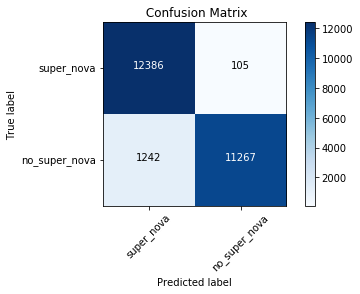

In [34]:
cm_plot_labels = ['super_nova','no_super_nova']
plot_confusion_matrix(cm,cm_plot_labels, title = ' Confusion Matrix')



In [35]:
print('       ESTADISTICAS      \n')
print('Valor máximo :', x_train.max())
print('Valor mínimo :', x_train.min())
print('Valor promedio :', x_train.mean())
print('Valor varianza :', x_train.var())
print('Valor desviación standar :', x_train.std())

       ESTADISTICAS      

Valor máximo : 1.0
Valor mínimo : 0.0
Valor promedio : 0.43186674
Valor varianza : 0.040720943
Valor desviación standar : 0.20179431


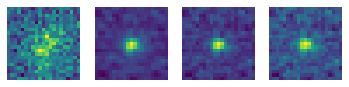

In [36]:
indeximage=4

for i in range(4):
    plt.subplot(1, 4, i+1)
    ximg=example_dict['images'][:,:,:,i]
    plt.imshow(ximg[indeximage])
    plt.axis('off')

plt.show()


In [37]:
%tensorboard --logdir logs/scalars

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/home/endredra/anaconda3/bin/tensorboard", line 11, in <module>
    sys.exit(run_main())
  File "/home/endredra/anaconda3/lib/python3.7/site-packages/tensorboard/main.py", line 64, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/home/endredra/anaconda3/lib/python3.7/site-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/home/endredra/anaconda3/lib/python3.7/site-packages/absl/app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "/home/endredra/anaconda3/lib/python3.7/site-packages/tensorboard/program.py", line 228, in main
    server = self._make_server()
  File "/home/endredra/anaconda3/lib/python3.7/site-packages/tensorboard/program.py", line 309, in _make_server
    self.assets_zip_provider)
  File "/home/endredra/anaconda3/lib/python3.7/site-packages/tensorboard/backend/application.py", line 16

In [38]:
predictions_t = new_model.predict(r_x_test[2:3])
print(r_x_test[2:3].shape)
print(predictions_t)

(1, 21, 21, 1)
[[0.04035088 0.95964915]]


In [39]:
predictions_t = new_model.predict(r_x_test)
print(r_x_test.shape)
print(predictions_t[2])

(25000, 21, 21, 1)
[0.04035085 0.95964915]


In [40]:
predictions_t = new_model.predict(np.expand_dims(r_x_test[2], axis=0))
print(np.expand_dims(r_x_train[2], axis=0).shape)
print(np.argmax(predictions_t))

(1, 21, 21, 1)
1
